In [53]:
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
from matplotlib.colors import Normalize


https://pypsa.readthedocs.io/en/latest/examples/scigrid-lopf-then-pf.html

In [67]:
network = pypsa.Network("../results/test_scenario/postnetworks/base_s_52_lv1.27___2035.nc")
network

C:\Users\kunde\anaconda3\envs\esm-2024\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
C:\Users\kunde\anaconda3\envs\esm-2024\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
C:\Users\kunde\anaconda3\envs\esm-2024\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float

PyPSA Network
Components:
 - Bus: 479
 - Carrier: 71
 - Generator: 963
 - GlobalConstraint: 3
 - Line: 106
 - Link: 2121
 - Load: 259
 - StorageUnit: 45
 - Store: 217
Snapshots: 88

In [68]:
# Lines
loading_line = abs(network.lines_t.p0) / network.lines.s_nom_opt
loading_line_ave = loading_line.mean() * 100

# Links
neglect_link = network.links.query("carrier != 'DC'").index

links_t_p0 = network.links_t.p0.copy()
links_t_p0.loc[:, neglect_link] = 0

links_p_nom_opt = network.links.p_nom_opt.copy()
links_p_nom_opt[neglect_link] = 0

loading_link = abs(links_t_p0) / links_p_nom_opt
loading_link = loading_link.fillna(0)
loading_link_ave = loading_link.mean()  * 100

loading_link_alpha = pd.Series(index=network.links.index)
loading_link_alpha[neglect_link] = 0
loading_link_alpha = loading_link_alpha.fillna(1)


In [75]:
loading_link_alpha[network.links.query("carrier != 'DC'").index]

Link
EU oil refining                                0.0
co2 sequestered                                0.0
AT0 0 OCGT-2035                                0.0
BE0 0 OCGT-2035                                0.0
CH0 0 OCGT-2035                                0.0
                                              ... 
SE1 0 urban decentral gas boiler-2019          0.0
SE1 0 urban decentral gas boiler-2035          0.0
SE1 0 urban decentral oil boiler-2019          0.0
SE1 0 urban decentral resistive heater-2019    0.0
SE1 0 urban decentral resistive heater-2035    0.0
Length: 2067, dtype: float64

In [69]:
line_weight = pd.DataFrame(index=loading_line.columns)

line_weight["by_cap"] = [network.lines.s_nom_opt[i] / network.lines.s_nom_opt.sum() for i in line_weight.index]
line_weight["by_cap_length"] = [network.lines.s_nom_opt[i] * network.lines.length[i] / (network.lines.s_nom_opt * network.lines.length).sum() for i in line_weight.index]
loading_line_ave_all = round(sum(line_weight["by_cap_length"] * loading_line_ave),1)

In [70]:
link_weight = pd.DataFrame(index=network.links.index)

link_weight["by_cap"] = [links_p_nom_opt[i] / links_p_nom_opt.sum() for i in link_weight.index]
link_weight["by_cap_length"] = [links_p_nom_opt[i] * network.links.length[i] / (links_p_nom_opt * network.links.length).sum() for i in link_weight.index]
loading_link_ave_all = round(sum(link_weight["by_cap_length"] * loading_link_ave),1)

C:\Users\kunde\anaconda3\envs\esm-2024\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


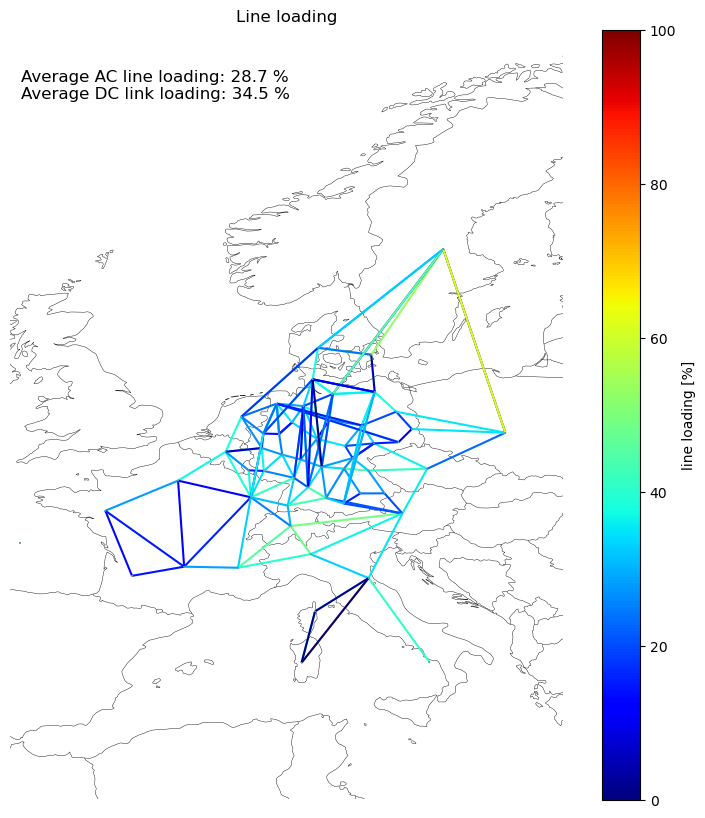

In [72]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 10))
norm = Normalize(vmin=0, vmax=100, clip=True)

collection = network.plot(
    ax=ax,
    line_colors=loading_line_ave,
    line_cmap=plt.cm.jet,
    line_norm=norm,
    link_colors=loading_link_ave,
    link_cmap=plt.cm.jet,
    link_alpha=loading_link_alpha,
    link_norm=norm,
    title="Line loading",
    bus_sizes=1e-3,
    bus_alpha=0.7,
    boundaries=[-6., 22., 33., 72.]
)
ax.set_title(f'Average AC line loading: {loading_line_ave_all} %\nAverage DC link loading: {loading_link_ave_all} %', 
          loc='left', 
          x=0.02, 
          y=0.90,
          fontsize=12
         )


plt.colorbar(collection[1], label="line loading [%]", ax=ax) #location="bottom",

